<a href="https://www.kaggle.com/code/shmel9va/dcgan?scriptVersionId=261999487" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from PIL import Image
import numpy as np
from tqdm import tqdm
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# DCGAN Generator
class DCGANGenerator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, feature_maps=64):
        super().__init__()
        self.model = nn.Sequential(
            # Input: z_dim x 1 x 1
            nn.ConvTranspose2d(z_dim, feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.ReLU(True),

            # State: (feature_maps*8) x 4 x 4
            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(True),

            # State: (feature_maps*4) x 8 x 8
            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),

            # State: (feature_maps*2) x 16 x 16
            nn.ConvTranspose2d(feature_maps * 2, feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),

            # State: (feature_maps) x 32 x 32
            nn.ConvTranspose2d(feature_maps, img_channels, 8, 8, 0, bias=False), # To 256x256
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

In [3]:
# DCGAN Discriminator 
class DCGANDiscriminator(nn.Module):
    def __init__(self, img_channels=3, feature_maps=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),  

            nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(feature_maps * 2, feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(feature_maps * 4, feature_maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(feature_maps * 8, 1, 16, 1, 0, bias=False), # To 1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)

In [4]:
# Dataset for Monet paintings only
class MonetOnlyDataset(Dataset):
    def __init__(self, root_monet, transform):
        self.monet_files = sorted(os.listdir(root_monet))
        self.monet_root = root_monet
        self.transform = transform

    def __len__(self):
        return len(self.monet_files)

    def __getitem__(self, idx):
        monet_path = os.path.join(self.monet_root, self.monet_files[idx])
        monet = self.transform(Image.open(monet_path).convert('RGB'))
        return monet

In [5]:
class MonetAndPhotoDataset(Dataset):
    def __init__(self, root_monet, root_photo, transform):
        self.files = sorted(os.listdir(root_monet)) + sorted(os.listdir(root_photo))
        self.roots = [root_monet]*len(os.listdir(root_monet)) + [root_photo]*len(os.listdir(root_photo))
        self.transform = transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        img_path = os.path.join(self.roots[idx], self.files[idx])
        img = self.transform(Image.open(img_path).convert('RGB'))
        return img

In [6]:
# Data augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])

In [7]:
# Hyperparameters
z_dim = 100
batch_size = 64
num_epochs = 100
lr = 2e-4
beta1 = 0.5
num_workers = 4

In [8]:
# Dataset and dataloader
dataset = MonetAndPhotoDataset(
    root_monet="/kaggle/input/gan-getting-started/monet_jpg",
    root_photo="/kaggle/input/gan-getting-started/photo_jpg",
    transform=transform
)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Models
G = DCGANGenerator(z_dim=z_dim).to(device)
D = DCGANDiscriminator().to(device)

# Optimizers and loss
optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
criterion = nn.BCELoss()

In [9]:
D_steps = 3  # number of discriminator updates per generator update

for epoch in range(1, num_epochs + 1):
    G.train(); D.train()
    for i, real_imgs in enumerate(tqdm(loader, desc=f"Epoch {epoch}/{num_epochs}")):
        real_imgs = real_imgs.to(device)
        batch = real_imgs.size(0)
        real_labels = torch.full((batch, 1), 0.9, device=device)
        fake_labels = torch.full((batch, 1), 0.0, device=device)

        # Train discriminator (D_steps times)
        for _ in range(D_steps):
            optimizer_D.zero_grad()
            # Real samples
            out_real = D(real_imgs)
            loss_real = criterion(out_real, real_labels)
            # Fake samples
            z = torch.randn(batch, z_dim, 1, 1, device=device)
            fake_imgs = G(z)
            out_fake = D(fake_imgs.detach())
            loss_fake = criterion(out_fake, fake_labels)
            # Total discriminator loss
            loss_D = loss_real + loss_fake
            loss_D.backward()
            optimizer_D.step()

        # Train generator (once)
        optimizer_G.zero_grad()
        z = torch.randn(batch, z_dim, 1, 1, device=device)
        fake_imgs = G(z)
        out_fake = D(fake_imgs)
        loss_G = criterion(out_fake, real_labels)
        loss_G.backward()
        optimizer_G.step()

    # Save checkpoints and clear cache
    if epoch % 10 == 0 or epoch == num_epochs:
        torch.save(G.state_dict(), f"/kaggle/working/DCGAN_G_epoch{epoch}.pth")
        torch.save(D.state_dict(), f"/kaggle/working/DCGAN_D_epoch{epoch}.pth")
    torch.cuda.empty_cache()
    print(f"Epoch {epoch}: D_loss={loss_D.item():.3f} G_loss={loss_G.item():.3f}")

print("Training finished!")

Epoch 1/100: 100%|██████████| 115/115 [01:41<00:00,  1.13it/s]


Epoch 1: D_loss=0.349 G_loss=42.114


Epoch 2/100: 100%|██████████| 115/115 [01:39<00:00,  1.15it/s]


Epoch 2: D_loss=0.343 G_loss=33.931


Epoch 3/100: 100%|██████████| 115/115 [01:39<00:00,  1.15it/s]


Epoch 3: D_loss=0.352 G_loss=46.220


Epoch 4/100: 100%|██████████| 115/115 [01:39<00:00,  1.15it/s]


Epoch 4: D_loss=0.343 G_loss=39.430


Epoch 5/100: 100%|██████████| 115/115 [01:39<00:00,  1.15it/s]


Epoch 5: D_loss=0.542 G_loss=33.409


Epoch 6/100: 100%|██████████| 115/115 [01:39<00:00,  1.15it/s]


Epoch 6: D_loss=0.830 G_loss=10.729


Epoch 7/100: 100%|██████████| 115/115 [01:39<00:00,  1.15it/s]


Epoch 7: D_loss=0.575 G_loss=5.702


Epoch 8/100: 100%|██████████| 115/115 [01:39<00:00,  1.15it/s]


Epoch 8: D_loss=2.736 G_loss=11.855


Epoch 9/100: 100%|██████████| 115/115 [01:39<00:00,  1.15it/s]


Epoch 9: D_loss=0.435 G_loss=4.795


Epoch 10/100: 100%|██████████| 115/115 [01:39<00:00,  1.15it/s]


Epoch 10: D_loss=1.974 G_loss=2.120


Epoch 11/100: 100%|██████████| 115/115 [01:39<00:00,  1.15it/s]


Epoch 11: D_loss=0.410 G_loss=8.737


Epoch 12/100: 100%|██████████| 115/115 [01:39<00:00,  1.15it/s]


Epoch 12: D_loss=0.389 G_loss=6.623


Epoch 13/100: 100%|██████████| 115/115 [01:39<00:00,  1.15it/s]


Epoch 13: D_loss=0.389 G_loss=8.598


Epoch 14/100: 100%|██████████| 115/115 [01:39<00:00,  1.15it/s]


Epoch 14: D_loss=0.669 G_loss=14.149


Epoch 15/100: 100%|██████████| 115/115 [01:39<00:00,  1.15it/s]


Epoch 15: D_loss=0.438 G_loss=5.138


Epoch 16/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 16: D_loss=0.376 G_loss=5.058


Epoch 17/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 17: D_loss=0.419 G_loss=6.749


Epoch 18/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 18: D_loss=0.365 G_loss=5.871


Epoch 19/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 19: D_loss=0.392 G_loss=5.500


Epoch 20/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 20: D_loss=0.415 G_loss=9.838


Epoch 21/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 21: D_loss=0.357 G_loss=5.825


Epoch 22/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 22: D_loss=0.376 G_loss=7.234


Epoch 23/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 23: D_loss=0.601 G_loss=6.229


Epoch 24/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 24: D_loss=0.478 G_loss=4.587


Epoch 25/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 25: D_loss=0.374 G_loss=6.172


Epoch 26/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 26: D_loss=0.367 G_loss=8.169


Epoch 27/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 27: D_loss=0.377 G_loss=4.897


Epoch 28/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 28: D_loss=0.361 G_loss=5.499


Epoch 29/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 29: D_loss=0.361 G_loss=6.436


Epoch 30/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 30: D_loss=0.372 G_loss=5.688


Epoch 31/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 31: D_loss=0.456 G_loss=4.572


Epoch 32/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 32: D_loss=0.363 G_loss=4.816


Epoch 33/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 33: D_loss=0.411 G_loss=5.559


Epoch 34/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 34: D_loss=0.365 G_loss=5.651


Epoch 35/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 35: D_loss=0.388 G_loss=4.768


Epoch 36/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 36: D_loss=0.363 G_loss=5.083


Epoch 37/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 37: D_loss=0.926 G_loss=4.514


Epoch 38/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 38: D_loss=0.418 G_loss=5.525


Epoch 39/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 39: D_loss=0.366 G_loss=4.951


Epoch 40/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 40: D_loss=0.380 G_loss=5.416


Epoch 41/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 41: D_loss=1.467 G_loss=4.572


Epoch 42/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 42: D_loss=0.372 G_loss=5.053


Epoch 43/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 43: D_loss=0.383 G_loss=5.842


Epoch 44/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 44: D_loss=0.377 G_loss=5.511


Epoch 45/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 45: D_loss=0.425 G_loss=5.030


Epoch 46/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 46: D_loss=0.382 G_loss=5.946


Epoch 47/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 47: D_loss=1.221 G_loss=7.327


Epoch 48/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 48: D_loss=0.360 G_loss=6.246


Epoch 49/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 49: D_loss=0.394 G_loss=6.658


Epoch 50/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 50: D_loss=0.353 G_loss=5.389


Epoch 51/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 51: D_loss=0.355 G_loss=5.403


Epoch 52/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 52: D_loss=0.366 G_loss=5.442


Epoch 53/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 53: D_loss=0.385 G_loss=8.022


Epoch 54/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 54: D_loss=0.405 G_loss=6.783


Epoch 55/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 55: D_loss=0.357 G_loss=4.748


Epoch 56/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 56: D_loss=0.351 G_loss=6.094


Epoch 57/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 57: D_loss=0.361 G_loss=5.386


Epoch 58/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 58: D_loss=0.378 G_loss=8.394


Epoch 59/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 59: D_loss=0.357 G_loss=5.033


Epoch 60/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 60: D_loss=0.360 G_loss=5.491


Epoch 61/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 61: D_loss=0.402 G_loss=5.755


Epoch 62/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 62: D_loss=0.364 G_loss=5.671


Epoch 63/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 63: D_loss=0.369 G_loss=5.320


Epoch 64/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 64: D_loss=0.361 G_loss=5.503


Epoch 65/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 65: D_loss=0.390 G_loss=7.099


Epoch 66/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 66: D_loss=0.396 G_loss=5.617


Epoch 67/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 67: D_loss=0.354 G_loss=6.627


Epoch 68/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 68: D_loss=1.191 G_loss=5.297


Epoch 69/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 69: D_loss=0.414 G_loss=6.833


Epoch 70/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 70: D_loss=0.353 G_loss=6.909


Epoch 71/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 71: D_loss=0.374 G_loss=6.590


Epoch 72/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 72: D_loss=0.458 G_loss=4.643


Epoch 73/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 73: D_loss=0.351 G_loss=5.955


Epoch 74/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 74: D_loss=0.367 G_loss=6.174


Epoch 75/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 75: D_loss=0.555 G_loss=4.568


Epoch 76/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 76: D_loss=0.402 G_loss=6.618


Epoch 77/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 77: D_loss=0.359 G_loss=5.934


Epoch 78/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 78: D_loss=0.367 G_loss=5.389


Epoch 79/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 79: D_loss=0.349 G_loss=5.674


Epoch 80/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 80: D_loss=0.346 G_loss=5.465


Epoch 81/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 81: D_loss=0.366 G_loss=5.517


Epoch 82/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 82: D_loss=0.366 G_loss=7.213


Epoch 83/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 83: D_loss=0.433 G_loss=8.584


Epoch 84/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 84: D_loss=0.433 G_loss=7.925


Epoch 85/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 85: D_loss=0.531 G_loss=6.763


Epoch 86/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 86: D_loss=0.363 G_loss=6.180


Epoch 87/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 87: D_loss=0.367 G_loss=5.569


Epoch 88/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 88: D_loss=0.361 G_loss=5.267


Epoch 89/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 89: D_loss=0.366 G_loss=6.668


Epoch 90/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 90: D_loss=0.365 G_loss=6.069


Epoch 91/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 91: D_loss=0.340 G_loss=5.984


Epoch 92/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 92: D_loss=0.384 G_loss=5.983


Epoch 93/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 93: D_loss=0.349 G_loss=5.799


Epoch 94/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 94: D_loss=0.353 G_loss=6.224


Epoch 95/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 95: D_loss=0.355 G_loss=5.547


Epoch 96/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 96: D_loss=0.349 G_loss=6.209


Epoch 97/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 97: D_loss=0.344 G_loss=6.181


Epoch 98/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 98: D_loss=0.376 G_loss=7.773


Epoch 99/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 99: D_loss=0.398 G_loss=8.503


Epoch 100/100: 100%|██████████| 115/115 [01:39<00:00,  1.16it/s]


Epoch 100: D_loss=0.345 G_loss=5.937
Training finished!


In [10]:
# Generate images for submission
output_dir = "/kaggle/working/gen_images_dcgan"
os.makedirs(output_dir, exist_ok=True)
G.eval()
num_samples = 7000  # number of images to generate

with torch.no_grad():
    for i in tqdm(range(num_samples)):
        z = torch.randn(1, z_dim, 1, 1, device=device)
        fake_img = G(z).cpu().squeeze(0)
        img_np = (fake_img * 0.5 + 0.5).clamp(0, 1).numpy().transpose(1, 2, 0)
        img_np = (img_np * 255).astype(np.uint8)
        Image.fromarray(img_np).save(f"{output_dir}/{i:05d}.jpg", "JPEG")

# Create archive
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', output_dir)

100%|██████████| 7000/7000 [00:26<00:00, 262.32it/s]


'/kaggle/working/images.zip'

In [11]:
# MiFID (FID) for DCGAN: compare generated vs real Monet paintings

from torchvision.models import inception_v3
import torch.nn as nn
from scipy import linalg

def get_inception_features(images, model, batch_size=8):
    features = []
    model.eval()
    with torch.no_grad():
        for i in range(0, images.shape[0], batch_size):
            batch = images[i:i+batch_size].to(device)
            batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
            preds = model(batch)
            if isinstance(preds, tuple):  # for older torchvision versions
                preds = preds[0]
            preds = preds.detach().cpu().numpy()
            features.append(preds)
    features = np.concatenate(features, axis=0)
    return features

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

def compute_fid_dcgan(fake_images, real_images, batch_size=16):
    # compute FID between generated and real Monet paintings
    model = inception_v3(pretrained=False, transform_input=False).to(device)
    model.load_state_dict(torch.load("/kaggle/input/inception-v3-google-0cc3c7bd22-pth/inception_v3_google-0cc3c7bd.pth"))
    model.fc = nn.Identity()
    model.eval()

    # extract features
    fake_feats = get_inception_features(fake_images, model, batch_size)
    real_feats = get_inception_features(real_images, model, batch_size)

    mu_fake, sigma_fake = fake_feats.mean(axis=0), np.cov(fake_feats, rowvar=False)
    mu_real, sigma_real = real_feats.mean(axis=0), np.cov(real_feats, rowvar=False)

    fid = calculate_fid(mu_fake, sigma_fake, mu_real, sigma_real)
    return fid

# Collect generated and real images for FID
N = min(len(dataset), 300)  # limit for speed and fairness

# Real Monet paintings
real_imgs = []
for i in range(N):
    monet = dataset[i]
    real_imgs.append(monet)
real_imgs = torch.stack(real_imgs)[:N]

# Generated Monet paintings
G.eval()
fake_imgs = []
with torch.no_grad():
    for i in range(N):
        z = torch.randn(1, z_dim, 1, 1, device=device)
        fake_img = G(z).cpu().squeeze(0)
        fake_imgs.append(fake_img)
fake_imgs = torch.stack(fake_imgs)[:N]

# Compute FID
fid = compute_fid_dcgan(fake_imgs, real_imgs, batch_size=16)
print(f"FID (DCGAN): {fid:.4f}")

# If you really want MiFID (sum of two FIDs) for DCGAN
# Usually FID alone is used since there's only one domain
mifid = fid + fid
print(f"MiFID (DCGAN): {mifid:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


FID (DCGAN): 260.5446
MiFID (DCGAN): 521.0892


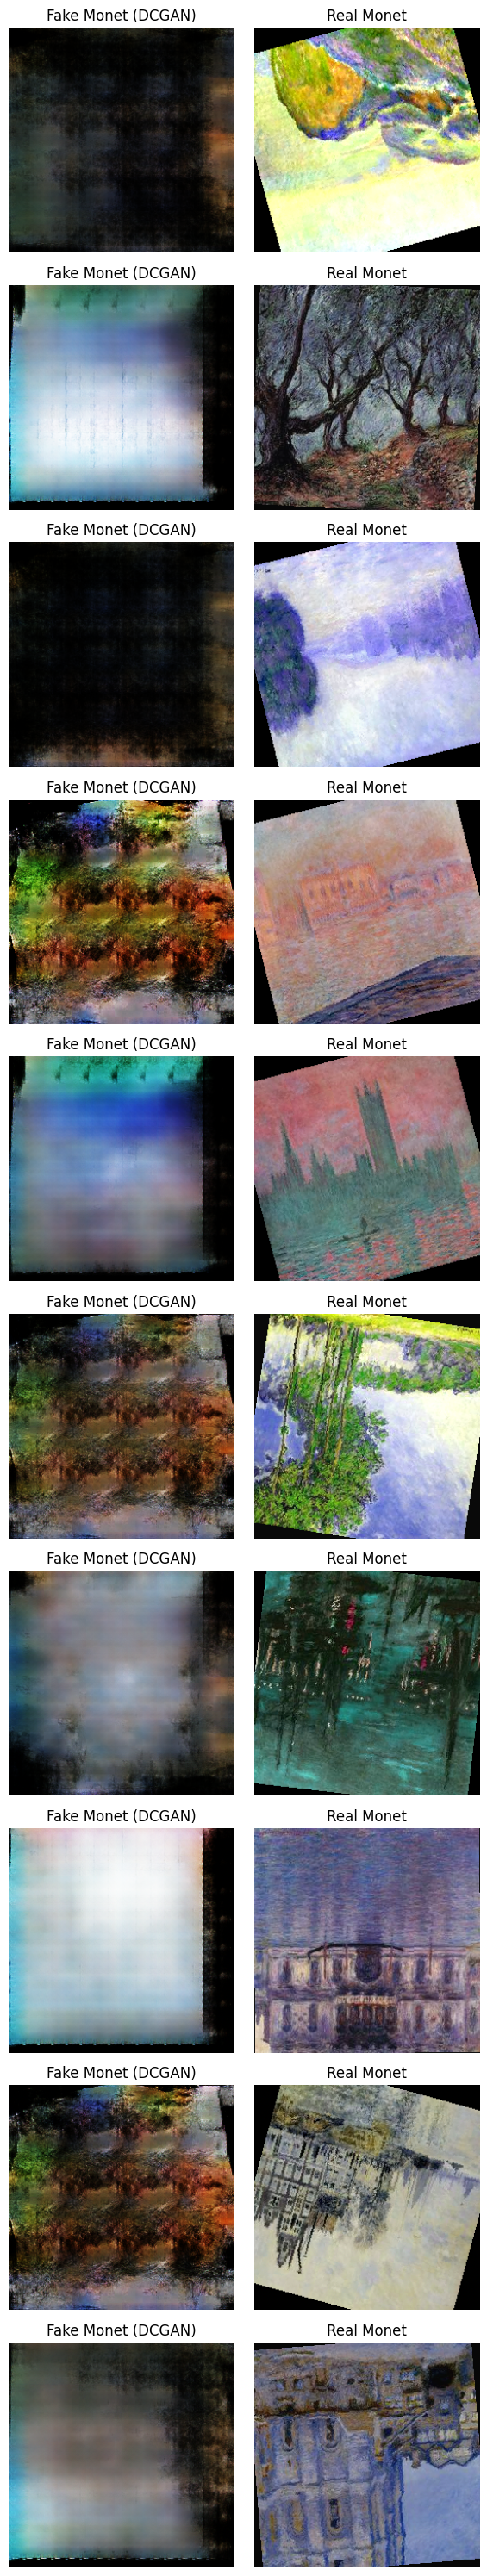

FID (DCGAN): 260.5446
MiFID (DCGAN): 521.0892


In [12]:
import matplotlib.pyplot as plt

# 1. Visualization of generated vs real Monet paintings
N_vis = 10  # number of examples to show

def denorm_dcgan(t):
    # assumes generator output in [-1, 1]
    t = t.detach().cpu()
    t = (t * 0.5) + 0.5
    return t.clamp(0, 1).permute(1, 2, 0).numpy()

fig, axs = plt.subplots(N_vis, 2, figsize=(6, 3 * N_vis))
for i in range(N_vis):
    # generated image
    axs[i, 0].imshow(denorm_dcgan(fake_imgs[i]))
    axs[i, 0].set_title('Fake Monet (DCGAN)')
    axs[i, 0].axis('off')
    # real image
    axs[i, 1].imshow(denorm_dcgan(real_imgs[i]))
    axs[i, 1].set_title('Real Monet')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

# 2. Compute FID/MiFID
fid = compute_fid_dcgan(fake_imgs, real_imgs, batch_size=16)
print(f"FID (DCGAN): {fid:.4f}")
mifid = fid + fid
print(f"MiFID (DCGAN): {mifid:.4f}")